# Naive Bayes Classifer from Scratch on Iris Fisher Dataset

In [1]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from scipy.stats import norm

In [2]:
# Load the data
data = load_iris()
f"Shape of Fisher's Iris data: {data.data.shape}" 

"Shape of Fisher's Iris data: (150, 4)"

## 1. Cross Validation

In [3]:
# Train-test split with 40 samples in training set and 10 samples in test set per class
X_train, X_test, Y_train, Y_test = train_test_split(data.data,
                                                    data.target,
                                                    test_size=0.2,
                                                    stratify=data.target,
                                                    random_state=42
                                                    )

### Summary of train-test split

In [4]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print(f"Number of samples in train_x: {X_train.shape[0]}")
print(f"Number of samples in test_x: {X_test.shape[0]}")
print(f"unique labels in train_y: {np.unique(Y_train)}")
print(f"number of samples per class in train_y: {np.bincount(Y_train)}")
print(f"unique labels in test_y: {np.unique(Y_test)}")
print(f"number of samples per class in test_y: {np.bincount(Y_test)}")


(120, 4) (30, 4) (120,) (30,)
Number of samples in train_x: 120
Number of samples in test_x: 30
unique labels in train_y: [0 1 2]
number of samples per class in train_y: [40 40 40]
unique labels in test_y: [0 1 2]
number of samples per class in test_y: [10 10 10]


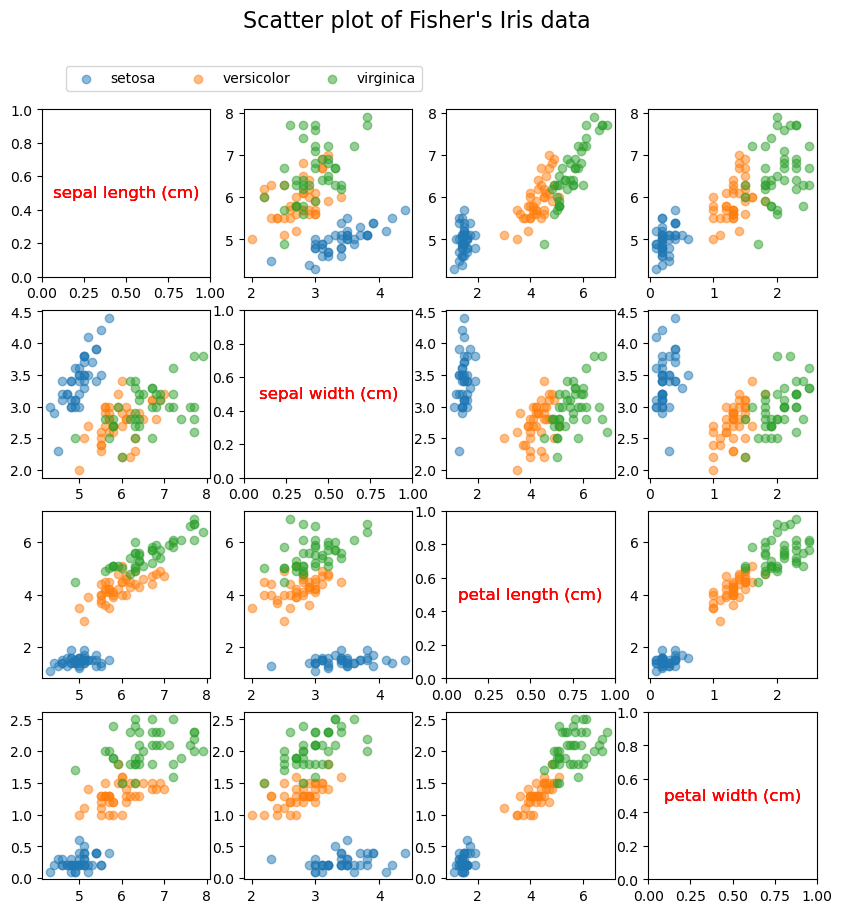

In [5]:
def plot_scatter_16(X_train: np.array, Y_train: np.array) -> None:
    """
    Scatter plot of Fisher's Iris data
    """
    fig, ax = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(4):
        for j in range(4):
            if i == j:
                for target in np.unique(Y_train):
                    # name of axis in the diagonal
                    ax[i, j].text(0.5, 0.5, data.feature_names[i],
                                 horizontalalignment='center',
                                 verticalalignment='center',
                                 fontsize=12, color='red',
                                 transform=ax[i, j].transAxes)
            else:
                for target in np.unique(Y_train):
                    ax[i, j].scatter(X_train[Y_train == target, j],
                                     X_train[Y_train == target, i],
                                     alpha=0.5)
    
    # legend of the plot outside on the top
    ax[0, 1].legend(data.target_names,
                    loc='upper center',
                    bbox_to_anchor=(0.0, 1.3),
                    fancybox=True,
                    ncol=3)
    
    # title of the plot
    plt.suptitle("Scatter plot of Fisher's Iris data", fontsize=16)
                    
    plt.show()
plot_scatter_16(X_train, Y_train)

## 2. Likelihood

In [6]:
def likelihood(X: np.array, mean: np.array, std: np.array) -> np.array:
    """
    Calculate the likelihood of the data given the mean and standard deviation
    likelihood = P(X|y) = P(x1|y) * P(x2|y) * P(x3|y) * P(x4|y)

    Use probability density function (PDF) of the Gaussian distribution
    to calculate the likelihood of observing each feature value given 
    the mean and standard deviation.
    """
    # norm.pdf() calculates the probability density function of the normal distribution.
    # np.prod() calculates the product of all likelihoods for all features.
    # Since the features are assumed to be independent,
    # we can multiply their individual likelihoods.
    return np.prod(norm.pdf(X, mean, std))

def mean_std(X_train: np.array, Y_train: np.array, n_classes: int=3) -> tuple:
    """
    Calculate the mean and standard deviation for each feature in each category
    """
    # 3 categories, 4 features
    mean = np.zeros((n_classes, X_train.shape[1]))
    std = np.zeros((n_classes, X_train.shape[1]))

    for category in range(n_classes):
        X_cat = X_train[Y_train == category]
        mean[category] = np.mean(X_cat, axis=0)
        std[category] = np.std(X_cat, axis=0)

    return mean, std

## 3. Priori

In [7]:
def prior_probs(Y_train: np.array) -> float:
    """
    Calculate the prior probability of each category
    prior = P(y)

    return: the probability of each category
    """
    # np.bincount: count the number of occurrences of each value in train_y
    # len(Y_train): total number of samples
    return np.bincount(Y_train) / len(Y_train)

## 4. Posterior

In [8]:
def posterior_probs(X_train: np.array, X_test: np.array, Y_train: np.array, n_classes: int=3) -> np.array:
    """
    Calculate the posterior probabilities of each category for each sample
    posterior = P(y|x) = P(x|y) * P(y)
    """
    # Initialize posterior probabilities
    posterior_probs_ = np.zeros((len(X_test), n_classes))
    # Calculate mean and standard deviation
    mean, std = mean_std(X_train, Y_train)

    for i, x in enumerate(X_test):
        for category in range(n_classes):
            # Calculate likelihood
            likelihood_ = likelihood(x, mean[category], std[category])
            # Calculate posterior probability
            posterior_probs_[i, category] = likelihood_ * prior_probs(Y_train)[category]

    # Normalize posterior probabilities
    posterior_probs_ /= np.sum(posterior_probs_, axis=1, keepdims=True)
    return posterior_probs_

## 5. Performance Evaluation

In [9]:
def predict(X_train: np.array, X_test: np.array, Y_train: np.array, n_classes: int=3) -> np.array:
    """
    Predict the category of each sample
    """
    posterior_probs_ = posterior_probs(X_train, X_test, Y_train, n_classes)
    # return the category with the highest probability
    return np.argmax(posterior_probs_, axis=1)

def confusion_matrix(predictions: np.array, Y_test: np.array, n_classes: int=3) -> np.array:
    """
    Calculate the confusion matrix
    """
    # actual class is the row, predicted class is the column
    confusion_matrix = np.zeros((n_classes, n_classes))

    for i in range(len(predictions)):
        confusion_matrix[Y_test[i], predictions[i]] += 1

    return confusion_matrix

def precision(confusion_matrix: np.array) -> np.array:
    """
    Calculate the precision
    Precision is the ratio of correctly predicted positive observations to the total predicted positives
    """
    # np.diag(confusion_matrix) returns the true positive
    # np.sum(confusion_matrix, axis=0) returns the sum of the column
    return np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)

def recall(confusion_matrix: np.array) -> np.array:
    """
    Calculate the recall
    Recall is the ratio of correctly predicted positive observations to the all observations in actual class
    """
    return np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)

def f1_score(precision: np.array, recall: np.array) -> np.array:
    """
    Calculate the F1 score
    F1 score is the weighted average of Precision and Recall
    """
    return 2 * (precision * recall) / (precision + recall)

def accuracy(predictions: np.array, Y_test: np.array) -> float:
    """
    Calculate the accuracy
    Accuracy is the ratio of correctly predicted observations to the total observations
    """
    return np.mean(predictions == Y_test)

## 6. Generate Samples

In [10]:
def generated_samples(mean: np.array,
                      std: np.array,
                      prior_probs: np.array,
                      n_samples: int=10,
                      n_classes: int=3, 
                      n_features: int=4) -> tuple:
    """
    Generate samples based on the Gaussian Naive Bayes model
    generated_samples = P(x|y) * P(y)
    """
    # Initialize the generated samples and category
    generated_samples_ = np.zeros((n_samples, n_features))
    category = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        # Randomly choose the category based on the prior probability
        category[i] = np.random.choice(n_classes, p=prior_probs)
        # Generate samples based on the mean and standard deviation of the category
        generated_samples_[i] = np.random.normal(mean[category[i]], std[category[i]])

    return generated_samples_, category

## 7. Evaluation

In [11]:
def evaluate(X_train: np.array,
             X_test: np.array,
             Y_train: np.array,
             Y_test: np.array,
             n_classes: int=3) -> tuple:
    """
    Evaluate the model. 
    Calculate the confusion matrix, precision, recall, F1 score, and accuracy.
    """
    predictions = predict(X_train, X_test, Y_train, n_classes=n_classes)
    conf_matrix = confusion_matrix(predictions, Y_test, n_classes=n_classes)
    prec = precision(conf_matrix)
    rec = recall(conf_matrix)
    f1 = f1_score(prec, rec)
    acc = accuracy(predictions, Y_test)

    return conf_matrix, prec, rec, f1, acc

In [12]:
results = evaluate(X_train, X_test, Y_train, Y_test)
print(f"Results of the evaluation:")
print(f"\nConfusion matrix: \n{results[0]}")
print(f"\nPrecision: {results[1]}")
print(f"\nRecall: {results[2]}")
print(f"\nF1 score: {results[3]}")
print(f"\nAccuracy: {results[4]}")

Results of the evaluation:

Confusion matrix: 
[[10.  0.  0.]
 [ 0.  9.  1.]
 [ 0.  0. 10.]]

Precision: [1.         1.         0.90909091]

Recall: [1.  0.9 1. ]

F1 score: [1.         0.94736842 0.95238095]

Accuracy: 0.9666666666666667


In [13]:
# Generate 10 samples
X_gen, Y_gen = generated_samples(mean_std(X_train, Y_train)[0],
                                    mean_std(X_train, Y_train)[1],
                                    prior_probs(Y_train))

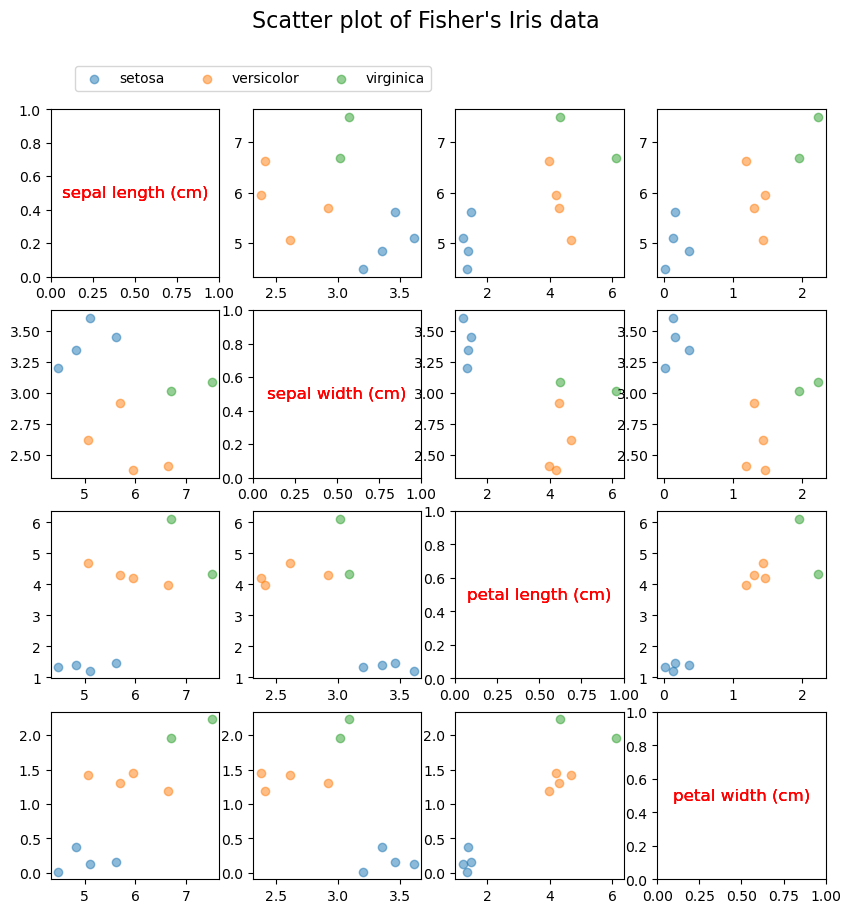

In [14]:
plot_scatter_16(X_gen, Y_gen)